# Model

Ran on google colab.

- 01_get_data.ipynb was run locally. Tomato images are not part of the repo, i.e. have to be copied by hand to be available in this notebook

In [1]:
!git clone https://github.com/stepheugarden/tomato.git

Cloning into 'tomato'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 22 (delta 6), reused 12 (delta 3), pack-reused 0
Unpacking objects: 100% (22/22), 1020.84 KiB | 9.37 MiB/s, done.


In [2]:
!ls ./drive/MyDrive

'Colab Notebooks'   data_del   data.zip   first-order-model-demo-ricardo


In [3]:
!unzip ./drive/MyDrive/data.zip

Archive:  ./drive/MyDrive/data.zip
   creating: data/
   creating: data/alternaria_canker/
  inflating: data/alternaria_canker/1992b5ba-dcb6-405a-96ee-902139fb99cf.jpg  
  inflating: data/alternaria_canker/79b46f49-69c5-466b-88fd-569bca2fd613.jpg  
  inflating: data/alternaria_canker/1ab393b5-7815-4ee4-b327-fd3be3616a27.JPG  
  inflating: data/alternaria_canker/c40fce59-f5aa-4792-8658-7d8a1e1cb9a7.jpg  
  inflating: data/alternaria_canker/7eff1982-15d5-4743-b2fc-edec45203758.JPG  
  inflating: data/alternaria_canker/bc908df7-0863-4bdf-acf6-e04e62b3f373.jpg  
  inflating: data/alternaria_canker/13ebf58a-5419-441d-8393-f4cc9849bb9e.jpg  
  inflating: data/alternaria_canker/dd20ca13-b2d5-4a5c-ac67-e3b29f1b1023.jpg  
  inflating: data/alternaria_canker/671df348-45f1-48b5-8970-c2f25a2d77f5.jpg  
  inflating: data/alternaria_canker/5d047385-a49a-4fb7-bb6b-05f4f94f3e79.jpg  
  inflating: data/alternaria_canker/b21f77e9-5d5f-47b6-8287-5d6c4a4ced94.png  
  inflating: data/alternaria_canker/a2de

In [4]:
import os
from fastai.vision.all import *
from fastcore.all import *

In [5]:
os.chdir("tomato")
data_path = "../data"

In [6]:
from src.mappings import *
print(f"length: {len(tomato_map)}")
print(f"example: {tomato_map['alternaria canker']}")

length: 17
example: sym_ctr(type='disease', symptoms='Symptoms of Alternaria canker appear on stems, leaves and fruit. Large areas of the leaf lamina between veins is killed, leading to leaf curling and eventual death of the entire leaf.', control='Fungus overwinters in crop residue and is easily spread by wind. Wounding of young plants (by mechanical damage or pruning) provides an entry site for infection. Furrow or drip irrigation is preferred over sprinkler irrigation. Preventative fungicide sprays may be required if a “zero tolerance” for defects production system is needed.')


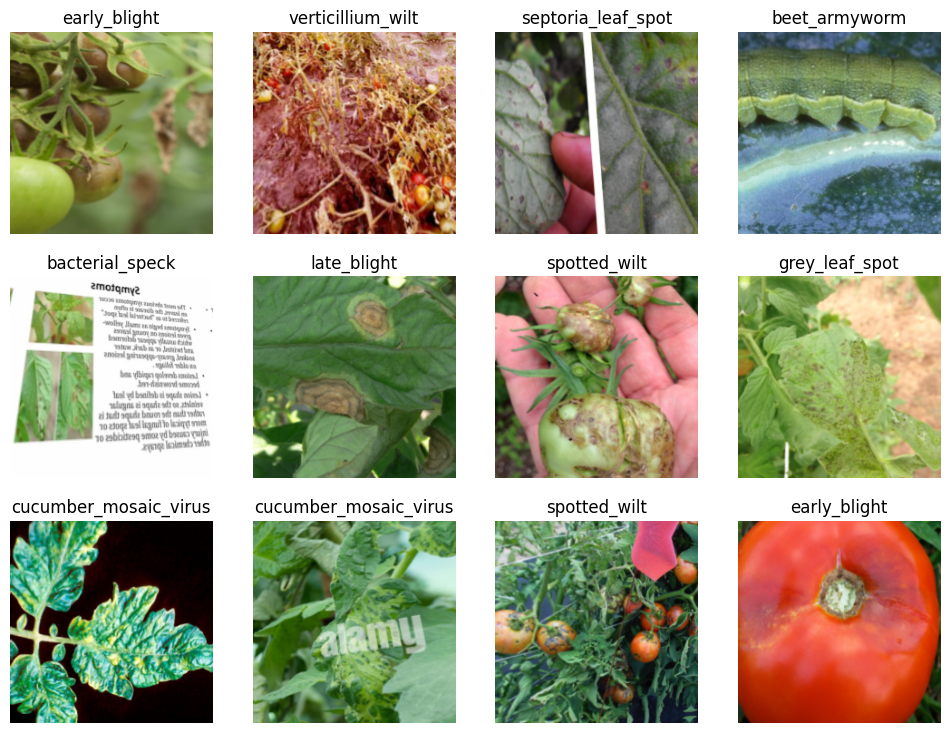

In [7]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()    
).dataloaders(data_path, bs=32)

dls.show_batch(max_n=12)

In [8]:
learn = vision_learner(dls, models.resnet18, error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,time
0,3.650834,2.720320,01:47


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


epoch,train_loss,valid_loss,time
0,2.811389,2.362179,01:45
1,2.546205,2.268245,01:51
2,2.131314,2.059608,01:43
3,1.816732,2.045022,01:42


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only

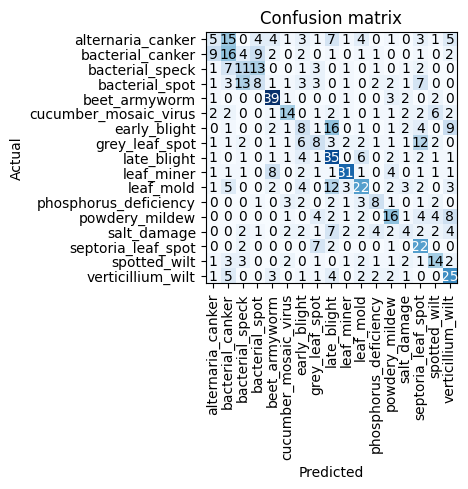

In [9]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Discussion
This easy model shows:
- most classes where predicted adequately
- there is still some missclassification. Mainly in:
  - alternaria and bacterial canker
  - bacterial speck and spot
  - early blight not very good
  - leaf mold and early blight
  - salt damage not very confident

It is hard not to confuse these classes when looking at images in the corresponding folder. One remedy would be to combine certain classes as the images are very similar and it is not clear (to me) if the downloaded images are really belonging to the assigned classes. 
We could also combine very uncertain classified pictures into a common class, that collects these uncertain classes.


Combining data:

In [10]:
dest_parent = "../data_combined"
os.system(f"rm -rf {dest_parent}")

os.makedirs(dest_parent, exist_ok=True)

combine = {
    'alternaria_canker': 'canker' ,
    'bacterial_canker': 'canker',
    'bacterial_speck': 'speck_spot',
    'bacterial_spot': 'speck_spot',
    'late_blight': 'blight_mold',
    'early_blight': 'blight_mold', 
    'spotted_wilt': 'blight_mold', 
    'cucumber_mosaic_virus': 'blight_mold', 
    'leaf_mold': 'blight_mold',
    'grey_leaf_spot': 'leaf_spot',
    'septoria_leaf_spot': 'leaf_spot'

}

for root, dirs, files in os.walk(data_path):
  if len(files) == 0:
    continue
  dest_name = os.path.basename(root)
  if dest_name in combine:
    dest = os.path.join(dest_parent, combine[dest_name])
  else:
    dest = os.path.join(dest_parent, dest_name)
  os.makedirs(dest, exist_ok=True)
  os.system(f"cp -rf {root}/* {dest}")


Train model on combinded data:

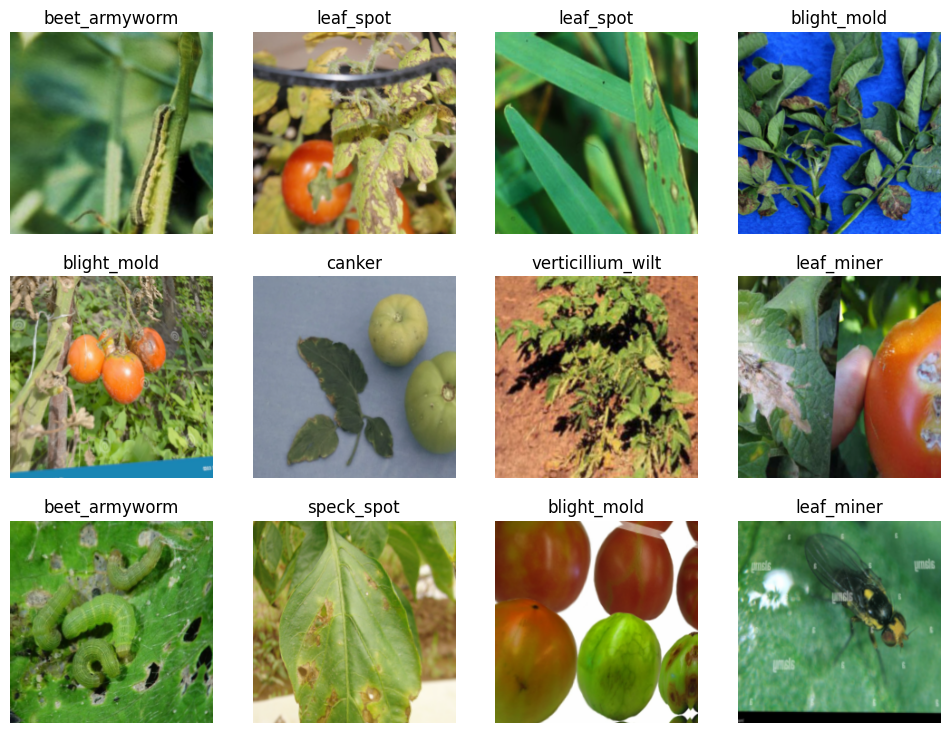

In [11]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()    
).dataloaders(dest_parent, bs=32)

dls.show_batch(max_n=12)

In [12]:
learn = vision_learner(dls, models.resnet34, error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,time
0,2.897646,1.997252,01:41


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,time
0,2.070115,1.783623,01:44
1,1.680704,1.511475,01:42
2,1.310596,1.470239,01:43


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only

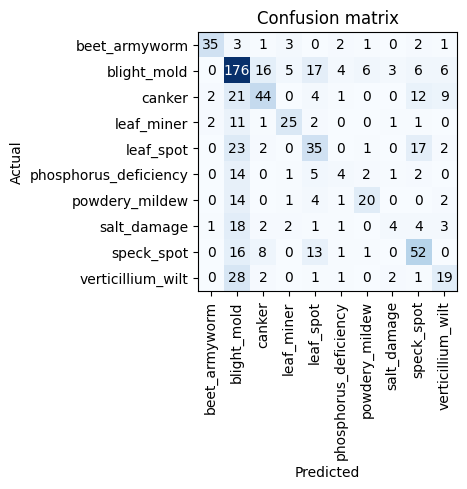

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

It seems that now the category *blight_mold* is too diverse and masks may of the other classes (or the images are not well chosen after all).

Anyway, export:

In [14]:
learn.export("/content/drive/MyDrive/export_tomato.pkl")